In [1]:
from __future__ import absolute_import, division, print_function

#@title Imports and defaults
%matplotlib inline

import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import sys

sys.path.append("..")

mpl.style.use("classic")
mpl.rcParams["figure.figsize"] = [5, 3]

mpl.rcParams["axes.linewidth"] = 0.75
mpl.rcParams["grid.linewidth"] = 0.75
mpl.rcParams["lines.linewidth"] = 0.75
mpl.rcParams["patch.linewidth"] = 0.75
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 7
mpl.rcParams["axes.titlesize"] = "medium"
mpl.rcParams["legend.fontsize"] = "medium"

print("matplotlib %s" % mpl.__version__)

from bandits.simulator import *
from bandits.algorithms import *
from bandits.phe import *
from bandits.hse import *

def linestyle2dashes(style):
  if style == "--":
    return (3, 3)
  elif style == ":":
    return (0.5, 2.5)
  else:
    return (None, None)

matplotlib 3.2.2


 48: 0.04 0.98 |  33: 0.02 0.90 |  30: 0.09 0.99 |  22: 0.06 0.94 |   6: 0.01 0.94 |  14: 0.09 0.95 |  38: 0.07 0.98 |  22: 0.10 0.93 |  18: 0.05 0.95 |  41: 0.06 0.97 | 
  2: 0.04 0.92 |  45: 0.10 0.99 |  14: 0.03 0.96 |   7: 0.14 0.96 |  30: 0.03 0.98 |  13: 0.04 0.98 |  38: 0.03 0.95 |  44: 0.04 0.92 |  46: 0.02 0.99 |  22: 0.03 0.94 | 
Evaluating Lin History-Swapping.................... 2.8 seconds
Regret: 134.39 +/- 43.67 (median: 23.23, max: 606.78, min: 19.55)
Evaluating Lin History-Swapping.................... 58.7 seconds
Regret: 35.22 +/- 5.18 (median: 23.53, max: 114.37, min: 18.68)
Evaluating Lin History-Swapping.................... 58.7 seconds
Regret: 37.12 +/- 6.84 (median: 26.94, max: 149.21, min: 3.78)
Evaluating Lin History-Swapping.................... 59.7 seconds
Regret: 59.81 +/- 15.87 (median: 27.01, max: 298.49, min: 20.60)
Evaluating Lin History-Swapping.................... 62.8 seconds
Regret: 32.02 +/- 4.26 (median: 29.39, max: 97.89, min: -13.20)
Evaluating L

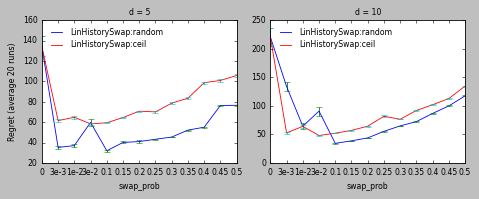

In [8]:
import datetime

reward_noise = "normal"

swap_probs = [0, 3e-3, 1e-2, 3e-2, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
swap_probs_labels = ['0', '3e-3', '1e-2', '3e-2', '0.1', '0.15', '0.2', '0.25', 
                     '0.3', '0.35', '0.4', '0.45', '0.5'] 

x_axis = np.arange(len(swap_probs))
num_runs = 20
n = 10000
K = 50

plt.figure(figsize=(6, 2.5))
algs = ['LinHistorySwap']
colors = {'LinHistorySwap':'red'}

for fig in range(2):
  if fig == 0:
    d = 5
  elif fig == 1:
    d = 10
  else:
    d = 20
    
  env = []
  for run in range(num_runs):
    # standard d-dimensional basis (with a bias term)
    basis = np.eye(d)
    basis[:, -1] = 1

    # arm features in a unit (d - 2)-sphere
    X = np.random.randn(K, d - 1)
    X /= np.sqrt(np.square(X).sum(axis=1))[:, np.newaxis]
    X = np.hstack((X, np.ones((K, 1))))  # bias term
    X[: basis.shape[0], :] = basis

    # parameter vector in a (d - 2)-sphere with radius 0.5
    theta = np.random.randn(d - 1)
    theta *= 0.5 / np.sqrt(np.square(theta).sum())
    theta = np.append(theta, [0.5])

    # create environment
    env.append(LinBandit(X, theta, reward_noise))
    print("%3d: %.2f %.2f | " % (env[-1].best_arm,
      env[-1].mu.min(), env[-1].mu.max()), end="")
    if (run + 1) % 10 == 0:
      print()

  plt.subplot(1, 2, fig + 1)

  for alg in algs:
    for sample_method in ['random', 'ceil']:
        alg_class = eval(alg)
        regret_means = []
        regret_vars = []
        for swap_prob in swap_probs:
            if d < 14:
                regret, _ = evaluate_parallel(alg_class, 
                    {"swap_prob": swap_prob, "sample_method": sample_method}, env, n, num_process=12)
            else:
                regret, _ = evaluate(alg_class, 
                    {"swap_prob": swap_prob, "sample_method": sample_method}, env, n)

            cum_regret = regret.sum(axis=0)
            regret_means.append(cum_regret.mean())
            regret_vars.append(cum_regret.std()/np.sqrt(num_runs))

        plt.plot(x_axis, regret_means, dashes=linestyle2dashes('-'), label=alg+':'+sample_method)
        plt.errorbar(x_axis, regret_means, regret_vars, fmt="none")#, ecolor=colors[alg])
        plt.xticks(x_axis, swap_probs_labels)
    
  plt.title("d = %d" % d)
  plt.xlabel("swap_prob")
  if not fig:
    plt.ylabel("Regret (average {} runs)".format(num_runs))
  if fig <= 2:
    plt.legend(loc="upper left", frameon=False)  

plt.tight_layout()
now = datetime.datetime.now()
with open("../results/LinHS_vs_SwapProb_{}_{}_{}_{}.jpeg" \
          .format(now.month, now.day, now.hour, now.minute), "wb") as f:
  plt.savefig(f, format="jpeg", dpi=1200, bbox_inches=0)
plt.show()

  2: 0.10 0.99 |  49: 0.02 0.90 |  34: 0.01 0.96 |  28: 0.04 0.98 |  39: 0.09 0.97 |   2: 0.06 0.92 |  37: 0.11 0.98 |  32: 0.06 0.94 |   2: 0.02 0.95 |  34: 0.05 0.96 | 
 30: 0.04 0.96 |  29: 0.07 0.94 |  42: 0.03 0.96 |  32: 0.02 0.89 |  13: 0.05 0.99 |  13: 0.06 0.92 |   8: 0.02 0.96 |  10: 0.05 0.98 |  44: 0.03 0.89 |  43: 0.04 0.92 | 
 37: 0.13 0.94 |  15: 0.01 0.95 |  32: 0.06 0.92 |  42: 0.02 0.94 |  49: 0.02 0.99 |  15: 0.01 0.99 |  32: 0.01 0.93 |  32: 0.06 0.96 |  42: 0.07 0.99 |  35: 0.04 0.98 | 
 47: 0.09 0.98 |  26: 0.09 0.93 |  44: 0.11 0.95 |  15: 0.01 0.97 |   2: 0.03 0.99 |   8: 0.14 0.99 |  47: 0.03 0.93 |  44: 0.07 0.93 |  45: 0.07 0.98 |  32: 0.08 0.95 | 
 25: 0.01 0.94 |   9: 0.07 0.99 |   1: 0.04 0.93 |  36: 0.03 0.92 |  42: 0.03 0.89 |  15: 0.04 0.97 |  35: 0.05 0.95 |   5: 0.03 0.95 |  21: 0.01 0.96 |  47: 0.06 0.96 | 
 22: 0.04 0.96 |  15: 0.04 0.92 |  33: 0.04 0.97 |  19: 0.12 0.90 |  40: 0.05 0.96 |  28: 0.02 0.98 |  44: 0.06 0.96 |  27: 0.01 0.96 |  45: 0.03

Evaluating Lin HS-SampleWithReplacement.................................................................................................... 336.5 seconds
Regret: 34.09 +/- 1.55 (median: 29.62, max: 129.37, min: 21.34)
Evaluating Lin HS-SampleWithReplacement.................................................................................................... 337.7 seconds
Regret: 36.22 +/- 3.34 (median: 30.12, max: 351.25, min: 9.30)
Evaluating Lin HS-SampleWithReplacement.................................................................................................... 337.8 seconds
Regret: 34.80 +/- 1.17 (median: 31.48, max: 83.62, min: 9.12)
Evaluating Lin HS-SampleWithReplacement.................................................................................................... 336.8 seconds
Regret: 35.30 +/- 1.17 (median: 32.95, max: 101.68, min: 14.48)
Evaluating Lin HS-SampleWithReplacement............................................................................................

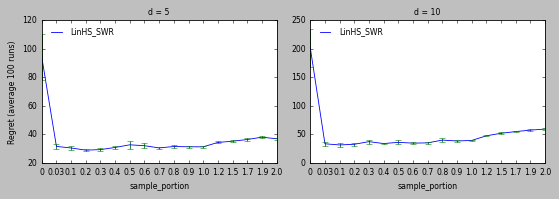

In [4]:
import datetime

reward_noise = "beta"

sample_portions = [0, 0.03, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                 0.7, 0.8, 0.9, 1.0, 1.2, 1.5, 1.7, 1.9, 2.0]
sample_portions_labels = [str(x) for x in sample_portions] 

x_axis = np.arange(len(sample_portions))
num_runs = 100
n = 10000
K = 50

plt.figure(figsize=(7, 2.5))
algs = ['LinHS_SWR']
colors = {'LinHS_SWR':'red'}

for fig in range(2):
  if fig == 0:
    d = 5
  elif fig == 1:
    d = 10
  else:
    d = 20
    
  env = []
  for run in range(num_runs):
    # standard d-dimensional basis (with a bias term)
    basis = np.eye(d)
    basis[:, -1] = 1

    # arm features in a unit (d - 2)-sphere
    X = np.random.randn(K, d - 1)
    X /= np.sqrt(np.square(X).sum(axis=1))[:, np.newaxis]
    X = np.hstack((X, np.ones((K, 1))))  # bias term
    X[: basis.shape[0], :] = basis

    # parameter vector in a (d - 2)-sphere with radius 0.5
    theta = np.random.randn(d - 1)
    theta *= 0.5 / np.sqrt(np.square(theta).sum())
    theta = np.append(theta, [0.5])

    # create environment
    env.append(LinBandit(X, theta, reward_noise))
    print("%3d: %.2f %.2f | " % (env[-1].best_arm,
      env[-1].mu.min(), env[-1].mu.max()), end="")
    if (run + 1) % 10 == 0:
      print()

  plt.subplot(1, 2, fig + 1)

  for alg in algs:
    alg_class = eval(alg)
    regret_means = []
    regret_vars = []
    for sample_portion in sample_portions:
        if d < 14:
            regret, _ = evaluate_parallel(alg_class, 
                {"sample_portion": sample_portion}, env, n, num_process=13)
        else:
            regret, _ = evaluate(alg_class, 
                {"sample_portion": sample_portion}, env, n)

        cum_regret = regret.sum(axis=0)
        regret_means.append(cum_regret.mean())
        regret_vars.append(cum_regret.std()/np.sqrt(num_runs))

    plt.plot(x_axis, regret_means, dashes=linestyle2dashes('-'), label=alg)
    plt.errorbar(x_axis, regret_means, regret_vars, fmt="none")#, ecolor=colors[alg])
    plt.xticks(x_axis, sample_portions_labels)
    
  plt.title("d = %d" % d)
  plt.xlabel("sample_portion")
  if not fig:
    plt.ylabel("Regret (average {} runs)".format(num_runs))
  if fig <= 2:
    plt.legend(loc="upper left", frameon=False)  

plt.tight_layout()
now = datetime.datetime.now()
with open("../exp_results/LinHS_SWR_normednoise_vs_SamplePortion_{}_{}_{}_{}_{}.jpeg" \
          .format(reward_noise, now.month, now.day, now.hour, now.minute), "wb") as f:
  plt.savefig(f, format="jpeg", dpi=1200, bbox_inches=0)
plt.show()